### Import necessary libraries and load the dataset

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as op
import tensorflow as tf # Tensorflow library
import keras # Keras library
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU, Rescaling # Keras library layers
from keras.layers import BatchNormalization, Conv2DTranspose, Concatenate # Keras library layers
from keras.models import Model, Sequential # Keras library model builders

from keras.optimizers import Adam # optimizer Adam
import tensorflow_datasets as tfds # datasets from Tensorflow

import matplotlib.pyplot as plt # graphing library
%matplotlib inline

Let's download a dataset with radiographic study data on COVID-19 c Kaggle.

In [ ]:
op.download("https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/")

Folder Structure:

In [ ]:
dataset_path = './covid19-radiography-database/COVID-19_Radiography_Dataset/Normal'

image_dir = 'images'
label_dir = 'masks'

### Data processing

In [ ]:
# Normalize input image and mask function
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0 # cast the data to float32 and divide the pixel intensity value by 255 for the input image
    input_mask -= 1 # mask has class 1, 2 and 3 values, cast it to 0, 1, 2
    return input_image, input_mask # return converted image and mask

In [ ]:
# Load image function
def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (160, 160)) # resize image to 160 x 160
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (160, 160)) # resize mask to 160 x 160

    input_image, input_mask = normalize(input_image, input_mask) # normalize image and mask

    return input_image, input_mask # return converted image and mask

In [ ]:
# Input dataset conversion pipelines for training and test samples
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(64).prefetch(1)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(64).prefetch(1)

### Visualization of individual dataset samples

Let's display some sample images from the dataset and their corresponding segmentation masks.

In [ ]:
# Image output function
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Image', 'Segmentation mask'] # define the titles of the graphs

    # In a loop, display images from display_list
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1) # output the area for plotting the graph
        plt.title(title[i]) # output the chart title
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))  # convert the matrix into an image and display it on the screen
        plt.axis('off') # disable axis display on the chart
    plt.show() # display the whole chart

In [ ]:
for images, masks in train_images.take(2): # take 2 instances from the package and display them on the screen using the display function
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

In [ ]:
original_image = os.path.join(dataset_path, image_dir, 'Normal-1.png') # path to the original image
label_image_semantic = os.path.join(dataset_path, label_dir, 'Normal-1.png') # path to the mask

fig, axs = plt.subplots(1, 2, figsize=(16, 8)) # set the area to be plotted (canvas)

img = np.array(load_img(original_image, target_size=(256, 256), color_mode='rgb'))   # load original image as RGB with 3 channels
mask = np.array(load_img(label_image_semantic, target_size=(256, 256), color_mode='grayscale')) # load the mask as "grayscale", i.e. in one channel

axs[0].imshow(img) # draw the original image
axs[0].grid(False)

axs[1].imshow(mask) # draw the mask (single channel image, each class is displayed as a separate color)
axs[1].grid(False)

### Network Architecture

In our example, we will take a modified U-net network structure, different from the one described in the original article. So, what we will change and why:

1. The images fed to the model input will be converted to a size of 160 x 160 px. We took the size of the images based on the limited resources of the colab.
2.  For all convolution layers `Conv2D` and “increasing convolution” `Conv2DTranspose` we will use `padding=“same”` out of personal preference, because it is easier to count matrix dimensions at the output of layers. We need to understand the matrix dimensions at the input and output of each layer in order to properly apply lateral joins.
3. Also tests have shown on this dataset that the result is better if we make small changes to the last layer and use a `3x3` kernel instead of `1x1`. And if segmentation means selecting several areas in the image, the last layer uses the `softmax` activation function instead of `sigmoid`. As in our case, the dataset contains 3 classes: the segmented object, the selection frame around the object, and the remaining area (let's call it the background). Using a similar approach, you can “highlight” multiple objects in an image, where each object is a different class. This is the task of multiclass segmentation and we will get acquainted with it in the next part of the lesson.

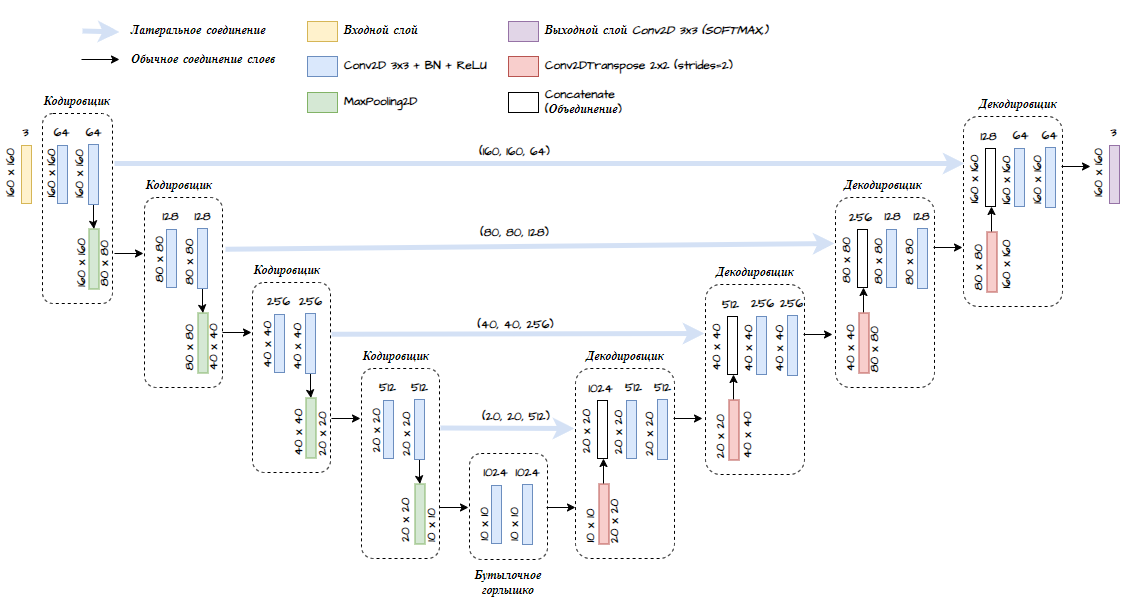

Figure 2. Architecture of the model we are going to train. We have slightly changed the labels for better clarity compared to the original article. For all layers, we specify the size of the output matrices (the number of feature maps at the top, the size of the feature maps at the output of the layer at the side). For MaxPooling2D and Conv2DTranspose layers, we specify 2 feature map sizes: at the input (left) and output (right). The lateral connections indicate the general shape of the transferred matrix.

Now based on this architecture graph we will assemble the whole model.

Let us declare the function of the convolution operation, which is shown as two consecutive blue blocks in Fig. 2.

In [ ]:
def convolution_operation(entered_input, filters=64):

    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    acti1 = ReLU()(batch_norm1)


    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(acti1)
    batch_norm2 = BatchNormalization()(conv2)
    acti2 = ReLU()(batch_norm2)

    return acti2

Next, let's declare the encoder and decoder functions according to Fig. 2.

In [ ]:
# Encoder function
# On input 2 parameters - previous layer and number of filters (generated feature maps)
def encoder(entered_input, filters=64):
    encod1 = convolution_operation(entered_input, filters) # convolution function - 2 blue blocks
    MaxPool1 = MaxPooling2D(strides = (2,2))(encod1) # green block
    return encod1, MaxPool1 # function returns lateral join and layer exit

# Decoder function
# Input 3 parameters - previous layer and lateral join and number of filters (generated feature maps)
def decoder(entered_input, skip, filters=64):
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input) # red block
    Connect_Skip = Concatenate()([Upsample, skip]) # white block (combining lateral connection and output of previous layer)
    out = convolution_operation(Connect_Skip, filters) # convolution function - 2 blue blocks
    return out # function returns output from layer

Let's assemble the entire network.

In [ ]:
# Our interpretation of the U-net model
def U_Net(img_size, num_classes):
    # The input layer is the yellow block
    inputs = Input(img_size)

    # Set encoder blocks and lateral connections
    skip1, encoder_1 = encoder(inputs, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)

    # Set the bottle neck with 2 blue blocks
    conv_block = convolution_operation(encoder_4, 64*16)

    # Define decoder blocks and pass lateral connections from encoders to it
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)

    # Output layer (purple block), its configuration depends on the problem to be solved
    outputs = Conv2D(num_classes, kernel_size = (3, 3), padding="same", activation="softmax")(decoder_4)

    model = Model(inputs, outputs)
    return model

In [ ]:
num_classes = 3 # 3 classes: background, segmented object and frame around the object
input_shape = (160, 160, 3) # size to which we convert the image, 3 channels - RGB
model = U_Net(input_shape, num_classes) # initialize model

In [ ]:
model.summary() # model structure report

In [ ]:
# model structure graph
tf.keras.utils.plot_model(model, "model.png", show_shapes=True, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=70)

### Model Training

As an error function, we take the discharged cross-categorical entropy. The main task of training is its minimization. As a metric we will derive accuracy. We will train on 30 epochs.

In [ ]:
model.compile(
    optimizer=Adam() ,
    loss="sparse_categorical_crossentropy",
    metrics=['sparse_categorical_accuracy']
)

callbacks = [
    keras.callbacks.ModelCheckpoint("segmentation.keras", save_best_only=True)
]

In [ ]:
epochs = 30
history = model.fit(train_images, epochs=epochs, validation_data=test_images, callbacks=callbacks)

### Analyzing learning outcomes

Let's look at the graph of accuracy and error function. We can see that still the accuracy is far from saturation and we can continue training. There is no overtraining yet. Usually, models for semantic segmentation are trained for 100 epochs with the `EarlyStopping' callback set to stop training early if the model stops improving.

In [ ]:
acc = history.history['sparse_categorical_accuracy'] # accuracy data on the training sample
val_acc = history.history['val_sparse_categorical_accuracy'] # accuracy data on the validation sample
loss = history. history['loss'] # error data on the training sample
val_loss = history.history['val_loss'] # error data on the validation sample
epochs = range(1, len(acc) + 1) # array with values for the abscissa axis (X)
plt.plot(epochs, acc, 'r', label='Precision on the training sample') # plot the precision on the training sample
plt.plot(epochs, val_acc, 'bo', label='Precision on the validation sample') # plot precision on the validation sample
plt.title('Plot of Precision on Training and Verification Samples') # plot title
plt.legend() # plot legend
plt.figure() # create a new figure (canvas for the chart)
plt.plot(epochs, loss, 'r', label='Losses on the training sample') # plot losses (error) on the training sample
plt.plot(epochs, val_loss, 'bo', label='Losses on validation sample') # plot losses on validation sample
plt.title('Plot of losses on training and validation samples') # plot title
plt.legend() # plot legend
plt.show()

In general, the result is not bad. Even on the test sample the result of accuracy of almost 90% was achieved.

### Visual evaluation of the segmentation result on the test sample

Let's compare the original mask and the predicted mask on the test sample. To do this, we will slightly modify the `display` function.

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input image', 'The original mask', 'The predicted mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[0])) # display the picture
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]),alpha=0.5) # display the mask with a transparency of 50%
        plt.axis('off')
    plt.show()

We define a mask creation function and display 12 sample images and their corresponding original and predicted masks.

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1) # argument index with maximal value, instead of probability by class we get
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


for image, mask in test_images.take(12): # select 12 images and output them in the loop
    pred_mask = model.predict(image[:1]) # predict the mask using the trained model
    display([image[0], mask[0], create_mask(pred_mask)]) # pass the image, the original mask and the predicted mask to the display function

In general, the original masks and those predicted on the test sample match. For more qualitative results it is necessary to perform additional augmentation of images. It is important to remember that if the transformation procedure is used for image augmentation: rotation, stretching, cropping, duplication, reflection, etc., the mask should be similarly transformed. Applying augmentation elements related to pixel intensity to the mask makes no sense and may even be harmful, since intensities determine the mask class.

Also, to improve segmentation quality, it is necessary to increase the number of training epochs and provide a callback for early stopping of the training process if the model stops learning.